In [1]:
import re
from copy import deepcopy

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
np.set_printoptions(precision=4)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
DATADIR = 'data/'
EMB_DIM = 50 # embedding dimension

In [4]:
def read_corpus(file):
    """
    returns:
        lines: [['hello', 'world'], ...]
        labels: [[!], [N], ...]
        vocab
    """
    with open(file, 'rt') as f:
        text = f.read()
    lines = text.split('\n\n')
    ret_lines = []
    labels = []
    vocab = set()
    for line in lines:
        if not line: 
            continue
        curr_line = []
        for token_label_str in line.split('\n'):
            if not token_label_str: 
                continue
            token, label = token_label_str.split('\t')
            vocab.add(token)
            labels.append(label)
            curr_line.append(token)
        ret_lines.append(curr_line)
    return ret_lines, labels, vocab

In [5]:
def encode_lines(lines, word2idx_map, window_size):
    """
    returns X: len(lines) x (2 * window_size + 1)
    """
    def encode_line(line, word2idx_map, window_size):
        num_repr = [] # numerical representation
        for word in line:
            num = word2idx_map.get(word, word2idx_map['UUUNKKK'])
            num_repr.append(num)
        # pad with start and end tokens
        start = [word2idx_map['<s>']] * window_size
        end = [word2idx_map['</s>']] * window_size
        padded = start + num_repr + end
        
        ret = []
        for i in range(window_size, len(padded) - window_size):
            windowed = padded[i - window_size : i + window_size + 1]
            ret.append(windowed)
            
        return ret
    
    res = []
    for line in lines:
        res.extend(encode_line(line, word2idx_map, window_size))
    return torch.tensor(res)

In [6]:
def construct_features(lines, features):
    """
    features: a set of characters to look for in each token
    also append to the end:
        (count features are normalized during training)
        - a count feature for digits
        - a count feature for the length of the entire token
    returns X: len(lines) x num_features
    """
    res = []
    for line in lines:
        for word in line:
            word_features = []
            char_set = set(word)
            for feature in features:
                val = 1 if feature in char_set else 0
                word_features.append(val)

            word_features.append(len(re.findall(r'\d', word))) # digit feature
            word_features.append(len(word)) # count feature
        
            res.append(word_features)

    return torch.tensor(res)

# Network

In [7]:
class FeedForwardTagger(nn.Module):
    
    def __init__(self, window_size, output_dim, emb_dim=EMB_DIM, 
                 vocab_size=None, pretrained_emb=None, freeze=False,
                num_binary_features=0, num_count_features=0):
        """
        vocab_size is None when using pretrained emb
        count features will be batch-normalized during forward
        """
        
        super(FeedForwardTagger, self).__init__()
        
        self.num_bin_feat = num_binary_features
        self.num_cnt_feat = num_count_features
        
        if pretrained_emb is None:
            self.emb = nn.Embedding(vocab_size, emb_dim)
            torch.nn.init.uniform_(self.emb.weight, -0.01, 0.01)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, freeze=freeze)
        
        input_dim = (2 * window_size + 1) * emb_dim
        input_dim += self.num_bin_feat + self.num_cnt_feat
        
        if self.num_cnt_feat != 0:
            self.batchnorm = nn.BatchNorm1d(self.num_cnt_feat)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, inputs):
        """
        input: [emb | binary features | count features]
        """
        num_feat = self.num_bin_feat + self.num_cnt_feat
        if num_feat != 0:
            to_embed = inputs[:, :-num_feat]
            bin_feats = inputs[:, -num_feat : -self.num_cnt_feat]
            cnt_feats = inputs[:, -self.num_cnt_feat:]
            
            # embed up to num_extra_features
            embeds = self.emb(to_embed).view((inputs.shape[0], -1))
            # normalize count features
            cnt_feats = self.batchnorm(cnt_feats.float())
            # concat emb w/ extra features
            x = torch.cat((embeds, bin_feats, cnt_feats), dim=1)
        else:
            x = self.emb(inputs).view((inputs.shape[0], -1))
            
        out = torch.tanh(self.fc1(x))
        out = self.fc2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [8]:
def train_util(model, X_train, Y_train, X_dev, Y_dev, n_epochs, lr, 
              batch_size):
    """
    returns: best_model, losses, train_accu_list, dev_accu_list
    """
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    best_model = None
    best_dev_accu = 0
    losses = []
    train_accu_list, dev_accu_list = [], []
    
    progress_bar = tqdm.trange(1, n_epochs + 1)
    for epoch in progress_bar:
        epoch_loss = 0
        
        for i in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()
            log_probs = model(X_train[i : i + batch_size])
            loss = loss_func(log_probs, Y_train[i : i + batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_preds = torch.argmax(model(X_train), dim=1)
        train_accu = accuracy_score(Y_train, train_preds)
        # evaluate on dev
        dev_preds = torch.argmax(model(X_dev), dim=1)
        dev_accu = accuracy_score(Y_dev, dev_preds)
        
        # early stopping, save the model if it has improved on dev
        if dev_accu > best_dev_accu:
            best_dev_accu = dev_accu
            best_model = deepcopy(model)
        
        progress_bar.set_description(
            'Epoch {}: train_loss {:.4f}, train_accu: {:.4f}, dev_accu: {:.4f}'\
              .format(epoch, epoch_loss, train_accu, dev_accu))
        losses.append(epoch_loss)
        train_accu_list.append(train_accu)
        dev_accu_list.append(dev_accu)
        
    loss_accu_df = pd.DataFrame({
        'epoch': range(1, n_epochs + 1), 
        'loss': losses,
        'train_accu': train_accu_list,
        'dev_accu': dev_accu_list})
        
    return best_model, loss_accu_df

# Plotting Utils

In [9]:
def plot_loss_accu(loss_accu_df_list, window_list):
    """
    input: two lists of the same length, loss_accu_df, window
    """
    dfs = []
    for df, w in zip(loss_accu_df_list, window_list):
        df1 = df.melt(
            'epoch', value_vars=['loss']).assign(window=w, plot='loss')
        df2 = df.melt(
            'epoch', value_vars=['train_accu', 'dev_accu']).assign(window=w, plot='accu')
        dfs.extend([df1, df2])
    plot_df = pd.concat(dfs)

    g = sns.FacetGrid(data=plot_df, row='plot', col='window', 
                      hue='variable', sharey=False)
    g.map_dataframe(sns.lineplot, x='epoch', y='value')
    g.add_legend()

def plot_confusion_matrix(matrix, labels, title):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, 
                     annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    ax.set_title(title)

# Load Data

In [10]:
train, train_labels, train_vocab = read_corpus(DATADIR + 'twpos-train.tsv')
dev, dev_labels, dev_vocab = read_corpus(DATADIR + 'twpos-dev.tsv')
devtest, devtest_labels, devtest_vocab = read_corpus(DATADIR + 'twpos-devtest.tsv')

In [11]:
all_labels = np.unique(train_labels)
all_labels_devtest = np.unique(devtest_labels) # devtest labels

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
Y_train = label_encoder.transform(train_labels)
Y_dev = label_encoder.transform(dev_labels)
Y_devtest = label_encoder.transform(devtest_labels)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_dev = torch.tensor(Y_dev, dtype=torch.long)
Y_devtest = torch.tensor(Y_devtest, dtype=torch.long)

In [12]:
# devtest labels
all_labels_devtest = np.unique(devtest_labels)

In [13]:
vocab = train_vocab.copy()
vocab.update(dev_vocab)
vocab.update(devtest_vocab)

# Record Accuracy

In [14]:
RECORD_ACCURACY = []

# 1. Baseline w/ Randomly Initialized Embeddings

In [15]:
# construct maps for randomly initialized embs
idx2word_rand = sorted(vocab)
idx2word_rand += ['<s>', '</s>', 'UUUNKKK']
word2idx_rand = {word: idx for idx, word in enumerate(idx2word_rand)}

## Encode Train, Dev, DevTest

In [16]:
# w = 0
X_train_w0 = encode_lines(train, word2idx_rand, window_size=0)
X_dev_w0 = encode_lines(dev, word2idx_rand, window_size=0)
X_devtest_w0 = encode_lines(devtest, word2idx_rand, window_size=0)

In [17]:
# w = 1
X_train_w1 = encode_lines(train, word2idx_rand, window_size=1)
X_dev_w1 = encode_lines(dev, word2idx_rand, window_size=1)
X_devtest_w1 = encode_lines(devtest, word2idx_rand, window_size=1)

## Train Model

### w = 0

In [18]:
model_w0 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=0,
                          output_dim=len(all_labels))
best_model_w0, df_w0 = train_util(model_w0, X_train_w0, Y_train, X_dev_w0, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=2000)

Epoch 25: train_loss 4.1660, train_accu: 0.8737, dev_accu: 0.7515: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s] 


In [19]:
# evaluate on devtest
devtest_preds = torch.argmax(best_model_w0(X_devtest_w0), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w0 = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 0, 'emb': 'random', 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.7618


### w = 1

In [20]:
model_w1 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=1,
                          output_dim=len(all_labels))
best_model_w1, df_w1 = train_util(model_w1, X_train_w1, Y_train, X_dev_w1, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 25: train_loss 2.4536, train_accu: 0.9701, dev_accu: 0.8141: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s] 


In [21]:
devtest_preds = torch.argmax(best_model_w1(X_devtest_w1), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1 = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 1, 'emb': 'random', 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8258


## Plot losses and accuracy, and confusion matrix

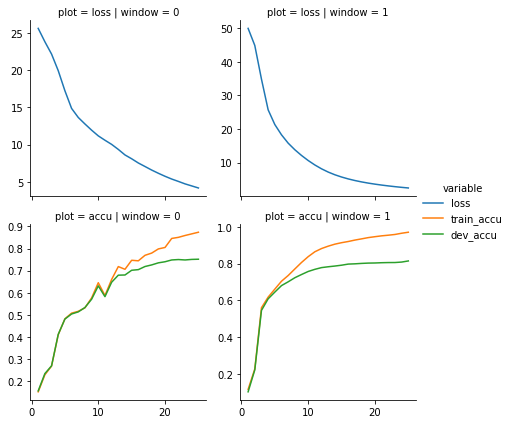

In [22]:
plot_loss_accu([df_w0, df_w1], window_list=[0, 1])

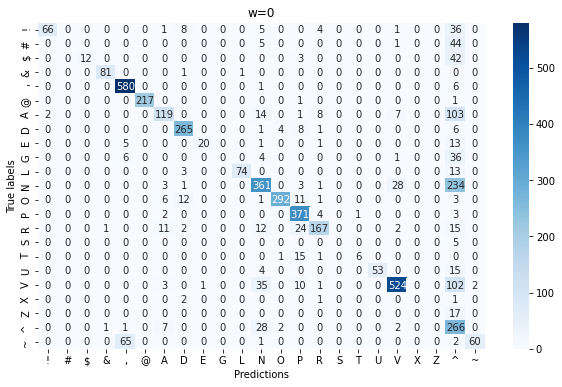

In [23]:
plot_confusion_matrix(conf_matrix_w0, all_labels_devtest, 'w=0')

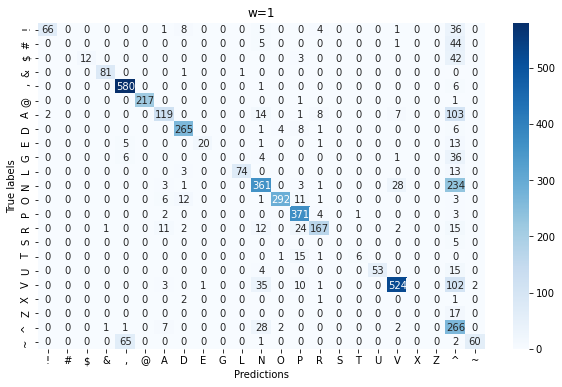

In [24]:
plot_confusion_matrix(conf_matrix_w0, all_labels_devtest, 'w=1')

# 2. Feature Engineering
In addition to the following binary features, I also added a count feature for digits and a count feature for the length of the entire token.

In [25]:
FEATURES = ['#', '%', "'", '/', ':', '’']

In [26]:
X_train_features = construct_features(train, FEATURES)
X_dev_features = construct_features(dev, FEATURES)
X_devtest_features = construct_features(devtest, FEATURES)

In [27]:
X_train_w0_feat = torch.cat((X_train_w0, X_train_features), dim=1)
X_dev_w0_feat = torch.cat((X_dev_w0, X_dev_features), dim=1)
X_devtest_w0_feat = torch.cat((X_devtest_w0, X_devtest_features), dim=1)

In [28]:
X_train_w1_feat = torch.cat((X_train_w1, X_train_features), dim=1)
X_dev_w1_feat = torch.cat((X_dev_w1, X_dev_features), dim=1)
X_devtest_w1_feat = torch.cat((X_devtest_w1, X_devtest_features), dim=1)

### W=0

In [29]:
model_w0_feat = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                                  window_size=0, 
                                  output_dim=len(all_labels),
                                 num_binary_features=len(FEATURES),
                                 num_count_features=2)
best_model_w0_feat, df_w0_feat = \
train_util(model_w0_feat, X_train_w0_feat, Y_train, X_dev_w0_feat, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 25: train_loss 4.6085, train_accu: 0.9208, dev_accu: 0.7849: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s] 


In [30]:
devtest_preds = torch.argmax(best_model_w0_feat(X_devtest_w0_feat), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w0_feat = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 0, 'emb': 'random', 'feature': True, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.7915


## w=1

In [31]:
model_w1_feat = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                                  window_size=1, 
                                  output_dim=len(all_labels),
                                 num_binary_features=len(FEATURES),
                                 num_count_features=2)
best_model_w1_feat, df_w1_feat = \
train_util(model_w1_feat, X_train_w1_feat, Y_train, X_dev_w1_feat, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 25: train_loss 2.2251, train_accu: 0.9681, dev_accu: 0.8386: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s] 


In [32]:
devtest_preds = torch.argmax(best_model_w1_feat(X_devtest_w1_feat), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1_feat = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 1, 'emb': 'random', 'feature': True, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8474


# 3. Pretrained Embeddings

In [36]:
twitter_vocab = []
twitter_emb = []
with open(DATADIR + 'twitter-embeddings.txt', 'rt') as f:
    for line in f:
        tokens = line.split(' ')
        word, emb = tokens[0], tokens[1:]
        emb = [float(elm) for elm in emb]
        twitter_vocab.append(word)
        twitter_emb.append(emb)

In [37]:
twitter_emb = torch.tensor(twitter_emb)
# for <s>, use the emb for </s>
idx2word_pretrained = twitter_vocab + ['<s>']
# construct maps for pretrained word embs
word2idx_pretrained = {word: idx for idx, word in enumerate(idx2word_pretrained)}
temp = twitter_emb[word2idx_pretrained['</s>']].view((1, -1))
twitter_emb = torch.cat((twitter_emb, temp))

## Encode Train, Dev, Devtest

In [38]:
# w = 0
X_train_w0_pre = encode_lines(train, word2idx_pretrained, window_size=0)
X_dev_w0_pre = encode_lines(dev, word2idx_pretrained, window_size=0)
X_devtest_w0_pre = encode_lines(devtest, word2idx_pretrained, window_size=0)

# w = 1
X_train_w1_pre = encode_lines(train, word2idx_pretrained, window_size=1)
X_dev_w1_pre = encode_lines(dev, word2idx_pretrained, window_size=1)
X_devtest_w1_pre = encode_lines(devtest, word2idx_pretrained, window_size=1)

## Train Model

### Fine-tuning emb

In [39]:
model_w0_tune = FeedForwardTagger(window_size=0, 
                                  output_dim=len(all_labels),
                                  pretrained_emb=twitter_emb)
best_model_w0_tune, df_w0_tune = \
train_util(model_w0_tune, X_train_w0_pre, Y_train, X_dev_w0_pre, Y_dev, 
                                  n_epochs=25, lr=0.5, batch_size=1000)

Epoch 25: train_loss 8.2567, train_accu: 0.8444, dev_accu: 0.8216: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s] 


In [40]:
devtest_preds = torch.argmax(best_model_w0_tune(X_devtest_w0_pre), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w0_tune = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 0, 'emb': 'pretrained', 'freeze': False, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8288


In [41]:
model_w1_tune = FeedForwardTagger(window_size=1, 
                                  output_dim=len(all_labels),
                                  pretrained_emb=twitter_emb)
best_model_w1_tune, df_w1_tune = \
train_util(model_w1_tune, X_train_w1_pre, Y_train, X_dev_w1_pre, Y_dev, 
                                  n_epochs=25, lr=0.5, batch_size=1000)

Epoch 25: train_loss 5.5695, train_accu: 0.9132, dev_accu: 0.8782: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


In [42]:
devtest_preds = torch.argmax(best_model_w1_tune(X_devtest_w1_pre), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1_tune = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 1, 'emb': 'pretrained', 'freeze': False, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8812


### Freeze emb

In [43]:
model_w1_freeze = FeedForwardTagger(window_size=1, 
                                  output_dim=len(all_labels),
                                  pretrained_emb=twitter_emb, freeze=True)
best_model_w1_freeze, df_w1_freeze = \
train_util(model_w1_freeze, X_train_w1_pre, Y_train, X_dev_w1_pre, Y_dev, 
                                  n_epochs=25, lr=0.5, batch_size=1000)

Epoch 25: train_loss 5.4824, train_accu: 0.9135, dev_accu: 0.8762: 100%|██████████| 25/25 [00:02<00:00, 11.34it/s]


In [44]:
devtest_preds = torch.argmax(best_model_w1_freeze(X_devtest_w1_pre), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1_freeze = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 1, 'emb': 'pretrained', 'freeze': True, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8795


### With features

In [45]:
X_train_w1_feat_pre = torch.cat((X_train_w1_pre, X_train_features), dim=1)
X_dev_w1_feat_pre = torch.cat((X_dev_w1_pre, X_dev_features), dim=1)
X_devtest_w1_feat_pre = torch.cat((X_devtest_w1_pre, X_devtest_features), dim=1)

In [46]:
model_w1_feat_tune = FeedForwardTagger(window_size=1, 
                                  output_dim=len(all_labels),
                                       pretrained_emb=twitter_emb,
                                 num_binary_features=len(FEATURES),
                                 num_count_features=2)
best_model_w1_feat_tune, df_w1_feat_tune = \
train_util(model_w1_feat_tune, X_train_w1_feat_pre, Y_train, X_dev_w1_feat_pre, Y_dev, 
                                  n_epochs=25, lr=0.5, batch_size=1000)

Epoch 25: train_loss 4.4685, train_accu: 0.9299, dev_accu: 0.8878: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


In [47]:
devtest_preds = torch.argmax(best_model_w1_feat_tune(X_devtest_w1_feat_pre), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w1_feat_tune = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 1, 'emb': 'pretrained', 'freeze': False, 'feature': True, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8926


# 4. Architecture Engineering

## w=2, random emb, no features baseline
Slightly better than w=0 or 1 baseline.

In [48]:
X_train_w2 = encode_lines(train, word2idx_rand, window_size=2)
X_dev_w2 = encode_lines(dev, word2idx_rand, window_size=2)
X_devtest_w2 = encode_lines(devtest, word2idx_rand, window_size=2)

In [49]:
model_w2 = FeedForwardTagger(vocab_size=len(word2idx_rand), 
                          window_size=2,
                          output_dim=len(all_labels))
best_model_w2, df_w2 = train_util(model_w2, X_train_w2, Y_train, X_dev_w2, Y_dev, 
                                  n_epochs=25, lr=2, batch_size=1000)

Epoch 25: train_loss 2.2265, train_accu: 0.9775, dev_accu: 0.8185: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s] 


In [50]:
devtest_preds = torch.argmax(best_model_w2(X_devtest_w2), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w2 = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 2, 'emb': 'random', 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8286


## w=2, using best config so far: pretrained emb, fine-tuning, features

Not too different from w=1, pretrained, fine-tuning, features

In [51]:
X_train_w2_pre = encode_lines(train, word2idx_pretrained, window_size=2)
X_dev_w2_pre = encode_lines(dev, word2idx_pretrained, window_size=2)
X_devtest_w2_pre = encode_lines(devtest, word2idx_pretrained, window_size=2)
X_train_w2_feat_pre = torch.cat((X_train_w2_pre, X_train_features), dim=1)
X_dev_w2_feat_pre = torch.cat((X_dev_w2_pre, X_dev_features), dim=1)
X_devtest_w2_feat_pre = torch.cat((X_devtest_w2_pre, X_devtest_features), dim=1)

In [52]:
model_w2_feat_tune = FeedForwardTagger(window_size=2, 
                                  output_dim=len(all_labels),
                                       pretrained_emb=twitter_emb,
                                 num_binary_features=len(FEATURES),
                                 num_count_features=2)
best_model_w2_feat_tune, df_w2_feat_tune = \
train_util(model_w2_feat_tune, X_train_w2_feat_pre, Y_train, X_dev_w2_feat_pre, Y_dev, 
                                  n_epochs=25, lr=0.5, batch_size=1000)

Epoch 25: train_loss 3.8113, train_accu: 0.9405, dev_accu: 0.8865: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


In [53]:
devtest_preds = torch.argmax(best_model_w2_feat_tune(X_devtest_w2_feat_pre), dim=1)
devtest_accu = accuracy_score(Y_devtest, devtest_preds)
conf_matrix_w2_feat_tune = confusion_matrix(Y_devtest, devtest_preds)
RECORD_ACCURACY.append({'w': 2, 'emb': 'pretrained', 'freeze': False, 'feature': True, 'devtest_accu': devtest_accu})
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8937


# Plots and Analysis

In [54]:
results_df = pd.DataFrame(RECORD_ACCURACY)

In [55]:
results_df

,w,emb,devtest_accu,feature,freeze
0,0,random,0.761802,NaN,NaN
1,1,random,0.825825,NaN,NaN
2,0,random,0.791550,True,NaN
3,1,random,0.847381,True,NaN
4,0,pretrained,0.828842,NaN,False
5,1,pretrained,0.881224,NaN,False
6,1,pretrained,0.879500,NaN,True
7,1,pretrained,0.892649,True,NaN
8,2,random,0.828627,NaN,NaN
9,2,pretrained,0.893727,True,False


## Confusion matrix using the best devtest accuray models

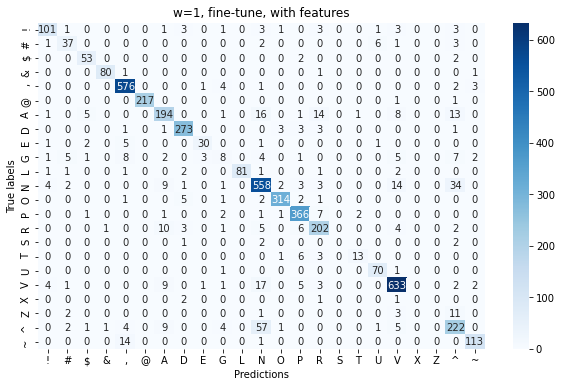

In [60]:
plot_confusion_matrix(conf_matrix_w1_feat_tune, all_labels_devtest, 'w=1, fine-tune, with features')

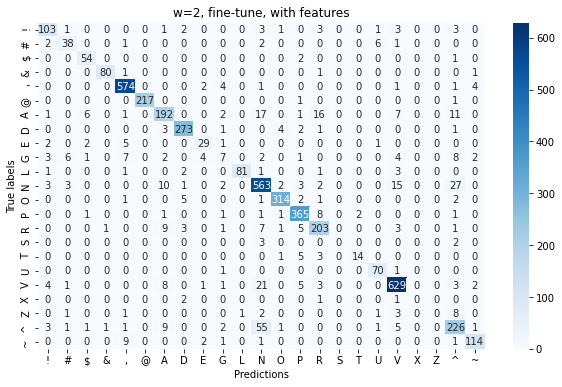

In [61]:
plot_confusion_matrix(conf_matrix_w2_feat_tune, all_labels_devtest, 'w=2, fine-tune, with features')

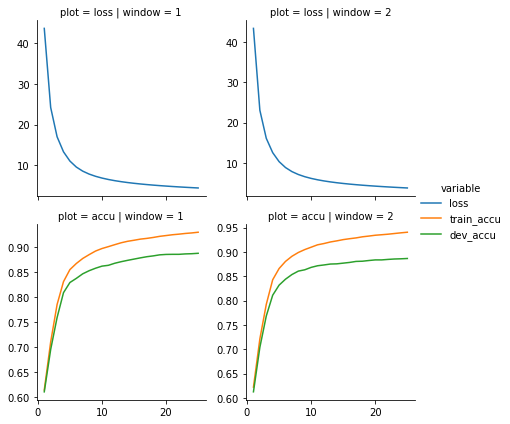

In [62]:
plot_loss_accu([df_w1_feat_tune, df_w2_feat_tune], window_list=[1, 2])